In [2]:
import cv2
import os
import glob as gb
import numpy as np
import pandas as pd
from collections import defaultdict

In [2]:
def segment_by_angle_kmeans(lines, k=2, **kwargs):
    """Groups lines based on angle with k-means.

    Uses k-means on the coordinates of the angle on the unit circle 
    to segment `k` angles inside `lines`.
    """

    # Define criteria = (type, max_iter, epsilon)
    default_criteria_type = cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER
    criteria = kwargs.get('criteria', (default_criteria_type, 10, 1.0))
    flags = kwargs.get('flags', cv2.KMEANS_RANDOM_CENTERS)
    attempts = kwargs.get('attempts', 10)

    # returns angles in [0, pi] in radians
    angles = np.array([line[0][1] for line in lines])
    # multiply the angles by two and find coordinates of that angle
    pts = np.array([[np.cos(2*angle), np.sin(2*angle)]
                    for angle in angles], dtype=np.float32)

    # run kmeans on the coords
    labels, centers = cv2.kmeans(pts, k, None, criteria, attempts, flags)[1:]
    labels = labels.reshape(-1)  # transpose to row vec

    # segment lines based on their kmeans label
    segmented = defaultdict(list)
    for i, line in enumerate(lines):
        segmented[labels[i]].append(line)
    segmented = list(segmented.values())
    return segmented

def intersection(line1, line2):
    rho1, theta1 = line1[0]
    rho2, theta2 = line2[0]
    A = np.array([
        [np.cos(theta1), np.sin(theta1)],
        [np.cos(theta2), np.sin(theta2)]
    ])
    b = np.array([[rho1], [rho2]])
    x0, y0 = np.linalg.solve(A, b)
    x0, y0 = int(np.round(x0)), int(np.round(y0))
    return [[x0, y0]]

def segmented_intersections(lines):
    intersections = []
    for i, group in enumerate(lines[:-1]):
        for next_group in lines[i+1:]:
            for line1 in group:
                for line2 in next_group:
                    intersections.append(intersection(line1, line2)) 

    return intersections

In [42]:
## image calibration

# define image path
path = "/home/bwkim/융복합공동연구/증강데이터/"
file_list = os.listdir(path)

for i in file_list:
    # image import
    globals()['original_data{}'.format(file_list.index(i))] = cv2.imread(path + i, cv2.IMREAD_COLOR)
    a0 = globals()['original_data{}'.format(file_list.index(i))]

    # change image contrast
    a1 = cv2.bitwise_not(a0)
    a2 = np.clip((1+10.0) * a1 - 128 * 10.0, 0, 255).astype(np.uint8)

    gray = cv2.cvtColor(a2, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 10, 50, apertureSize = 3)
    rho = 1
    theta = np.pi/180
    thresh = 200

    lines = cv2.HoughLines(edges, rho, theta, thresh)
    
    for rho, theta in lines[0]:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))

    height, width = a0.shape[:2]

    grad = (x2-x1)/(y2-y1)   # grad = -1.80206
    angle = np.arctan(grad)*180/np.pi

    M1 = cv2.getRotationMatrix2D((height/2, width/2), -angle, 1)
    a3 = cv2.warpAffine(a0, M1, (width, height))

    cv2.imwrite('/home/bwkim/융복합공동연구/전처리데이터/전처리데이터%s.jpg'%i, a3)

In [170]:
## extraction grid coordination

# define image path
path = "/home/bwkim/융복합공동연구/증강데이터/"
file_list = os.listdir(path)

# define parameters
left_up_x_list = []
right_up_x_list = []
left_down_x_list = []
right_down_x_list = []
left_up_y_list = []
right_up_y_list = []
left_down_y_list = []
right_down_y_list =[]
df_list = []

for i in file_list:
    # image import
    globals()['data{}'.format(file_list.index(i))] = cv2.imread(path + i, cv2.IMREAD_COLOR)
    a0 = globals()['data{}'.format(file_list.index(i))]

    # change image contrast
    a1 = cv2.bitwise_not(a0)
    a2 = np.clip((1+5.0) * a1 - 128 * 5.0, 0, 255).astype(np.uint8)

    #find grid line in image
    globals()['img{}'.format(file_list.index(i))] = a2.copy()
    globals()['img_original{}'.format(file_list.index(i))] = a2.copy()
    b0 = globals()['img{}'.format(file_list.index(i))]
    b1 = globals()['img_original{}'.format(file_list.index(i))]
    gray = cv2.cvtColor(b0, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 3, 15, apertureSize = 3)
    rho = 1
    theta = np.pi/180
    thresh = 200

    lines = cv2.HoughLines(edges, rho, theta, thresh)

    for j in range(len(lines)):
        for rho, theta in lines[j]:
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a*rho
            y0 = b*rho
            x1 = int(x0 + 1000*(-b))
            y1 = int(y0 + 1000*(a))
            x2 = int(x0 - 1000*(-b))
            y2 = int(y0 -1000*(a))

            cv2.line(b0,(x1,y1),(x2,y2),(0,0,255),2)

    segmented = segment_by_angle_kmeans(lines)
    
    intersections = segmented_intersections(segmented)

    df = pd.DataFrame(intersections)

    plus_xy = []
    minus_xy = []
    df['x'] = ""
    df['y'] = ""
    df['plus_xy'] = ""
    df['minus_xy'] = ""

    for i in range(len(intersections)):
        a = intersections[i][0][0]
        b = intersections[i][0][1]
        c = a+b
        d = a-b
        plus_xy.append(c)
        minus_xy.append(d)

        df['x'][i] = a
        df['y'][i] = b
        df['plus_xy'][i] = c
        df['minus_xy'][i] = d

    df = df[(df['x'] > 0) & (df['y'] > 0)]

    left_up = df['plus_xy'].min()
    right_up = df['minus_xy'].max()
    left_down = df['minus_xy'].min()
    right_down = df['plus_xy'].max()

    left_up_index = df.index[df['plus_xy'] == df['plus_xy'].min()]
    right_up_index = df.index[df['minus_xy'] == df['minus_xy'].max()]
    left_down_index = df.index[df['minus_xy'] == df['minus_xy'].min()]
    right_down_index = df.index[df['plus_xy'] == df['plus_xy'].max()]

    if len(left_up_index) > 1:
        a = df[df['x'] == min(df['x'])]
        left_up_x_value = a['x']
        left_up_x_list.append(left_up_x_value)
        b = df[df['y'] == min(df['y'])]
        left_up_y_value = b['y']
        left_up_y_list.append(left_up_y_value)
    else:
        left_up_x_value = df.loc[left_up_index]['x']
        left_up_x_list.append(left_up_x_value)
        left_up_y_value = df.loc[left_up_index]['y']
        left_up_y_list.append(left_up_y_value)
        
    if len(right_up_index) > 1:
        a = df[df['x'] == max(df['x'])]
        right_up_x_value = a['x']
        right_up_x_list.append(right_up_x_value)
        b = df[df['y'] == min(df['y'])]
        right_up_y_value = b['y']
        right_up_y_list.append(right_up_y_value)
    else:
        right_up_x_value = df.loc[right_up_index]['x']
        right_up_x_list.append(right_up_x_value)
        right_up_y_value = df.loc[right_up_index]['y']
        right_up_y_list.append(right_up_y_value)

    if len(left_down_index) > 1:
        a = df[df['x'] == min(df['x'])]
        left_down_x_value = a['x']
        left_down_x_list.append(left_down_x_value)
        b = df[df['y'] == max(df['y'])]
        left_down_y_value = b['y']
        left_down_y_list.append(left_down_y_value)
    else:
        left_down_x_value = df.loc[left_down_index]['x']
        left_down_x_list.append(left_down_x_value)
        left_down_y_value = df.loc[left_down_index]['y']
        left_down_y_list.append(left_down_y_value)

    if len(right_down_index) > 1:
        a = df[df['x'] == max(df['x'])]
        right_down_x_value = a['x']
        right_down_x_list.append(right_down_x_value)
        b = df[df['y'] == max(df['y'])]
        right_down_y_value = b['y']
        right_down_y_list.append(right_down_y_value)
    else:
        right_down_x_value = df.loc[right_down_index]['x']
        right_down_x_list.append(right_down_x_value)
        right_down_y_value = df.loc[right_down_index]['y']
        right_down_y_list.append(right_down_y_value)

    df_list.append(df)

In [248]:
## image resizing

# define image path
path = "/home/bwkim/융복합공동연구/증강데이터/"
file_list = os.listdir(path)

for i, j in zip (file_list[442:443], range(442,443)):#range(len(file_list))):
    # image import
    globals()['pre_data{}'.format(j)] = cv2.imread(path + i, cv2.IMREAD_COLOR)
    a0 = globals()['pre_data{}'.format(j)]
    
    a1 = a0[np.array(left_up_y_list[j])[0]:np.array(left_down_y_list[j])[0], 
            np.array(left_up_x_list[j])[0]:np.array(right_down_x_list[j])[0]:]

    a2 = cv2.resize(a1, (200, 200))
    
    # globals()['crop_data{}'.format(file_list.index(i))] = a2



error: OpenCV(4.5.5) /io/opencv/modules/imgproc/src/resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


In [214]:
a1 = a0[np.array(left_up_y_list[0])[0]:np.array(left_down_y_list[0])[0], np.array(left_up_x_list[0])[0]:np.array(right_down_x_list[0])[0]:]

In [217]:
a2 = cv2.resize(a1, dsize = (200, 200))

In [241]:
file_list[443]

'20221029_image138-crop.jpg'

In [245]:
import matplotlib.pyplot as plt
def show(img):
    plt.imshow(img)
    plt.show()

In [243]:
aaa = pre_data443[np.array(left_up_y_list[443])[0]:np.array(left_down_y_list[443])[0], 
            np.array(left_up_x_list[443])[0]:np.array(right_down_x_list[443])[0]:]

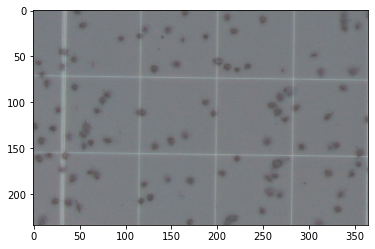

In [246]:
show(aaa)

In [247]:
bbb = cv2.resize(aaa, (200, 200))#, interpolation = cv2.INTER_CUBIC)

In [ ]:
good_list= [33,52,81,80,89,91,165,171,188,196,245,246,252,255,283,296,320,325,335,337,342,365,374,396,403,428,431,448,476,479,480,490,525, 533, 532, 543, 548, 560, 607, 621, 628, 630, 641, 653, 671, 677, 680, 785, 795, 796, 814, 819, 820, 829, 832, 851, 870, 907, 957, 971, 980]

path = "/home/bwkim/융복합공동연구/최종데이터/"

for i in good_list:
    # image import
    globals()['original_data{}'.format(good_list.index(i))] = cv2.imread('%s최종데이터%s.jpg'%(path,i), cv2.IMREAD_COLOR)
    a0 = globals()['original_data{}'.format(good_list.index(i))]
    cv2.imwrite('/home/bwkim/융복합공동연구/선별데이터/선별데이터%s.jpg'%i,a0)